In [37]:
%reload_ext autoreload
%reload_ext autoreload

In [81]:
import time
import os
import sys
import copy
import time
import datetime
import random
import math
import warnings
from functools import partial
# warnings.filterwarnings('ignore')

In [39]:
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torch import Tensor
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

In [74]:
import numpy as np
import scipy
import seaborn as sns

from tqdm.notebook import tqdm, trange

In [41]:
sys.path.append("../")

In [85]:
from chaosmining.data_utils import read_formulas, create_simulation_data
from chaosmining.simulation.models import MLPRegressor
from chaosmining.simulation.functions import abs_argmax_topk
from chaosmining.utils import radar_factory

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [44]:
from captum.attr import IntegratedGradients, Saliency, DeepLift, FeatureAblation

In [45]:
import matplotlib
# mpl.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt 
from matplotlib.colors import ListedColormap

matplotlib.rcParams['lines.linewidth'] = 1
matplotlib.rcParams['lines.markersize'] = 5
plt.rcParams['figure.figsize'] = [4, 4]

# Generate Functions and Data

In [19]:
formulas_path = '../data/symbolic_simulation/formula.csv'

In [20]:
formulas = read_formulas(formulas_path)

In [21]:
formula_id = 14
seed = 9999
test_size = 0.2
n_steps = 20

In [22]:
num_features, function = formulas[formula_id]

In [23]:
num_noises = 200
num_data = 10000
X_var = 0.33
y_var = 0.01
X, y_true, y_noise, intercepts, derivatives, integrations = create_simulation_data(function, num_features, num_noises, num_data, X_var, y_var, n_steps=n_steps)
print('X', X.shape, 'y true', y_true.shape, 'y noise', y_noise.shape, 
      'intercepts', len(intercepts), intercepts[0].shape,
      'derivatives', len(derivatives), derivatives[0].shape, 
      'integrations', len(integrations), integrations[0].shape)

X (10000, 210) y true (10000, 1) y noise (10000, 1) intercepts 10 (10000,) derivatives 10 (10000,) integrations 10 (10000,)


In [24]:
intercepts = np.stack(intercepts, axis=1)
derivatives = np.stack(derivatives, axis=1)
integrations = np.stack(integrations, axis=1)

In [25]:
y = y_true + y_noise

In [26]:
X_train, X_test, \
y_train, y_test, \
y_true_train, y_true_test, \
intercepts_train, intercepts_test, \
derivatives_train, derivatives_test, \
integrations_train, integrations_test \
= train_test_split(X, y, y_true, intercepts, derivatives, integrations, test_size=test_size, random_state=seed)

# Training and Test a MLP

In [59]:
train_set = TensorDataset(Tensor(X_train), Tensor(y_train))
train_loader = DataLoader(train_set, batch_size=y_train.shape[0], shuffle=True)
test_set = TensorDataset(Tensor(X_test), Tensor(y_true_test))
test_loader = DataLoader(test_set, batch_size=y_test.shape[0])

In [60]:
hidden_layer_sizes = (100,100,100)
num_epochs = 1000

In [61]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [62]:
model = MLPRegressor(num_features+num_noises, hidden_layer_sizes, p=0.0)
model.to(device)
model.train()

MLPRegressor(
  (blocks): ModuleList(
    (0): LinearBlock(
      (net): Sequential(
        (0): Linear(in_features=210, out_features=100, bias=True)
        (1): GELU(approximate='none')
      )
    )
    (1): LinearBlock(
      (net): Sequential(
        (0): Linear(in_features=100, out_features=100, bias=True)
        (1): GELU(approximate='none')
      )
    )
    (2): LinearBlock(
      (net): Sequential(
        (0): Linear(in_features=100, out_features=100, bias=True)
        (1): GELU(approximate='none')
      )
    )
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (project): Linear(in_features=100, out_features=1, bias=True)
)

In [63]:
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), 0.001)

In [77]:
def train(model, dataloader, num_epochs, optimizer):
    pbar = trange(num_epochs, desc='Train', unit='epoch', initial=0, disable=True)
    for epoch in pbar:  # loop over the dataset multiple times
        running_loss = 0.0
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            # forward pass
            outputs = model(inputs)
            # defining loss
            loss = criterion(outputs, targets)
            # zero the parameter gradients
            optimizer.zero_grad()
            # computing gradients
            loss.backward()
            # accumulating running loss
            running_loss += loss.item()
            # updated weights based on computed gradients
            optimizer.step()
        pbar.set_postfix(loss = '%.3f' % running_loss)
    print('train loss:', running_loss)

In [76]:
train(model, train_loader, num_epochs, optimizer)

In [78]:
y_pred = model(Tensor(X_test).to(device)).detach().cpu().numpy()

In [79]:
score = mean_absolute_error(y_pred, y_test)
print('Test mean absolute value is', score)

Test mean absolute value is 0.12094275727062029


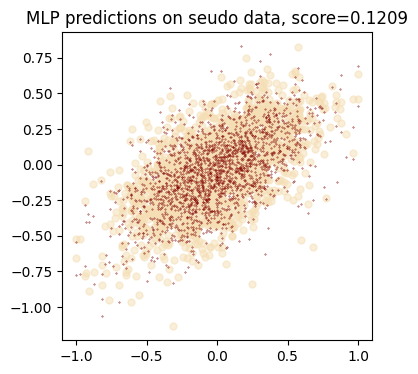

In [80]:
plt.scatter(X_test[:,0], y_test, c='wheat', alpha=0.5)
plt.scatter(X_test[:,0], y_pred, s=0.1, c='maroon', alpha=1)
plt.title(f"MLP predictions on seudo data, score={score:.4f}")
plt.show()

# Iterative Method

In [103]:
reduce_rate = 0.8
best_score = 10
num_cur_features = num_features+num_noises
select_arr = np.ones(num_cur_features)

In [104]:
while num_cur_features>0:
    bool_arr = np.array(select_arr, dtype='bool') 
    
    train_set = TensorDataset(Tensor(X_train[...,bool_arr]), Tensor(y_train))
    train_loader = DataLoader(train_set, batch_size=y_train.shape[0], shuffle=True)
    test_set = TensorDataset(Tensor(X_test[...,bool_arr]), Tensor(y_true_test))
    test_loader = DataLoader(test_set, batch_size=y_test.shape[0])

    model = MLPRegressor(int(np.sum(select_arr)), hidden_layer_sizes, p=0.0)
    model.to(device)
    model.train()

    criterion = nn.MSELoss(reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(), 0.001)

    train(model, train_loader, num_epochs, optimizer)

    model.eval()
    y_pred = model(Tensor(X_test[...,bool_arr]).to(device)).detach().cpu().numpy()
    score = mean_absolute_error(y_pred, y_test)
    print('score', score)

    if score > best_score:
        break
    else:
        best_score = score

    xai = Saliency(model)
    # xai = DeepLift(model)
    # xai = FeatureAblation(model)
    # xai = IntegratedGradients(model)

    num_remove = int(num_cur_features*(1-reduce_rate))
    if num_remove<1:
        break
    print('num_remove', num_remove)
    xai_attr_test = xai.attribute(Tensor(X_test[...,bool_arr]).to(device))
    abs_xai_attr_test = np.abs(xai_attr_test.detach().cpu().numpy()).mean(0)
    inds = np.argpartition(abs_xai_attr_test, num_remove)[:num_remove]
    print('inds', inds.shape)
    select_arr[inds] = 0
    num_cur_features -= num_remove

train loss: 2.821320208568068e-07
score 0.13054152108058797
num_remove 41
inds (41,)


/home/geshi/captum/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


train loss: 1.4568020560545847e-05
score 0.12254999805236448
num_remove 33
inds (33,)


/home/geshi/captum/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


train loss: 5.57193488930352e-05
score 0.09956250566424714
num_remove 27
inds (27,)


/home/geshi/captum/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


train loss: 0.00016765335749369115
score 0.0875765804458097
num_remove 21
inds (21,)


/home/geshi/captum/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


train loss: 0.0002333905576961115
score 0.07843630905549301
num_remove 17
inds (17,)


/home/geshi/captum/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


train loss: 0.00041324427002109587
score 0.07195427654145999
num_remove 14
inds (14,)


/home/geshi/captum/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


train loss: 0.00044801743933930993
score 0.06911792135775742
num_remove 11
inds (11,)


/home/geshi/captum/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


train loss: 0.0005844147526659071
score 0.06753567947393624
num_remove 9
inds (9,)


/home/geshi/captum/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


train loss: 0.0004577543877530843
score 0.0700454335870335


In [105]:
print('The best score is:', best_score)
print('best features:', np.where(select_arr==1)[0])

The best score is: 0.06753567947393624
best features: [  0   1   2   3   4   5   6   7   8  16  19  30  37  47  48  49  50  56
  61  62  63  66  71  74  77  90  91  92  94  97 104 107 108 109 111 114
 117 118 119 120 121 123 125 130 132 133 134 137 140 143 144 146 148 149
 150 151 153 156 158 160 162 163 166 167 169 170 171 172 173 174 179 180
 181 184 186 187 188 189 190 191 192 193 195 196 197 198 199 200 201 202
 203 204 205 206 207 208]
